# Earnest Sequence Project

## Requirements (by Vishnu)

We would like to use Earnest Database to find a correlation between Invoice Ids and Day, Month and Year over a period of time for 40 companies. Here are the elements:
 
1. Create a View for each company from Earnest database, that does the following:
    
    a. Eliminates time from the date-filed (timestamp is not reliable)
    
    b. Creates additional fields for Yr, Qtr, Month, Week#, Day

2. For each company create a scatter plot of order number by day
    
    a. Eliminate any characters
    
    b. Identify if any of the digits are denoting either year/qtr/month/week and separate them
    
    c. Identify any unusual bumps and explain them (eliminate these data points from the sequence, if necessary)

3. Finally, create a multi-variate linear regression (excel is good enough) for the company order numbers. Given a date we should be able to identify the order number range.

4. Show the t-stat and df-stat (all other output of regression and based on these and standard errors, outline the confidence level of order number prediction based on date

## Solution


In [2]:
import pandas as pd

# read CSV file
data = pd.read_csv('data/OrderNumSeq.csv')
data.head()

,invoice_id,order_date
0,P-102-7259-9819,01/10/11
1,P-103-9411-9011,09/10/11
2,P-103-3485-7262,25/10/11
3,P-103-5837-4851,02/11/11
4,P-103-8009-1414,08/11/11


In [3]:
data.shape

(25893, 2)

In [4]:
data.tail()

,invoice_id,order_date
25888,P-144-8565-4736,27/06/16
25889,P-144-8585-4733,27/06/16
25890,P-144-8605-4766,27/06/16
25891,P-144-8605-4788,27/06/16
25892,P-144-8615-4702,27/06/16


In [5]:
data['invoice_id'] = data['invoice_id'].str.replace('-', '').str[1:].astype(int)
data.head()

,invoice_id,order_date
0,10272599819,01/10/11
1,10394119011,09/10/11
2,10334857262,25/10/11
3,10358374851,02/11/11
4,10380091414,08/11/11


In [6]:
import datetime as dt
data['order_date'] = data['order_date'].apply(lambda x: dt.datetime.strptime(x, "%d/%m/%y"))
data.head()

,invoice_id,order_date
0,10272599819,2011-10-01
1,10394119011,2011-10-09
2,10334857262,2011-10-25
3,10358374851,2011-11-02
4,10380091414,2011-11-08


In [7]:
data['year'] = data['order_date'].apply(lambda x: x.year)
data['month'] = data['order_date'].apply(lambda x: x.month)
data['day'] = data['order_date'].apply(lambda x: x.day)

In [8]:
data.head()

,invoice_id,order_date,year,month,day
0,10272599819,2011-10-01,2011,10,1
1,10394119011,2011-10-09,2011,10,9
2,10334857262,2011-10-25,2011,10,25
3,10358374851,2011-11-02,2011,11,2
4,10380091414,2011-11-08,2011,11,8


In [12]:
# conventional way to import seaborn
import seaborn as sns

# allow plots to appear within the notebook
%matplotlib inline

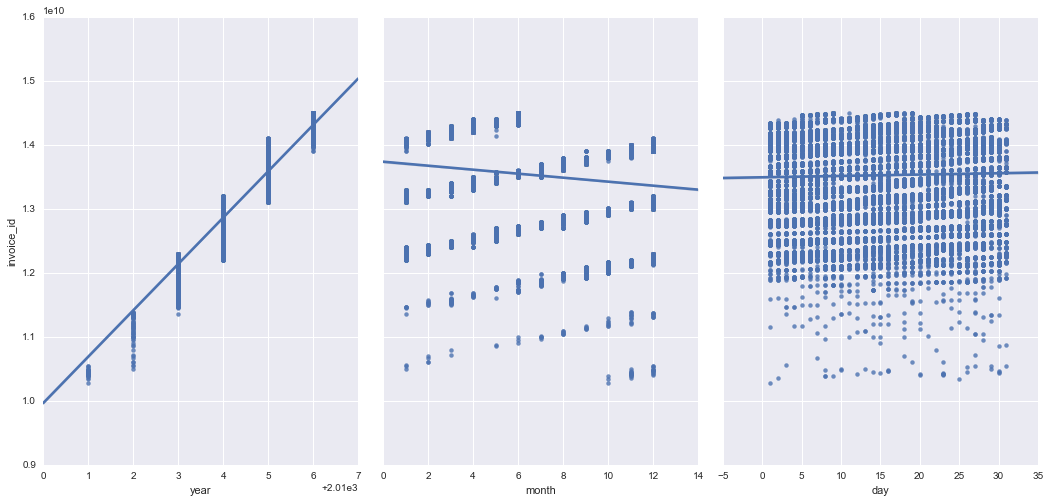

In [13]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=['year', 'month', 'day'], y_vars='invoice_id', size=7, aspect=0.7, kind='reg')

## Linear regression

**Pros:** fast, no tuning required, highly interpretable, well-understood

**Cons:** unlikely to produce the best predictive accuracy (presumes a linear relationship between the features and response)

### Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

In this case:

$y = \beta_0 + \beta_1 \times year + \beta_2 \times month + \beta_3 \times day$

The $\beta$ values are called the **model coefficients**. These values are "learned" during the model fitting step using the "least squares" criterion. Then, the fitted model can be used to make predictions!


## Preparing X and y using pandas

- We shall use scikit-learn toolkit to run the linear regression.
- X (feature matrix) is a pandas DataFrame and y (response vector) is a pandas Series!

In [21]:
# create a Python list of feature names
feature_cols = ['year', 'month', 'day']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# print the first 5 rows
X.head()

,year,month,day
0,2011,10,1
1,2011,10,9
2,2011,10,25
3,2011,11,2
4,2011,11,8


In [22]:
# select a Series from the DataFrame
y = data['invoice_id']
y.head()

0    10272599819
1    10394119011
2    10334857262
3    10358374851
4    10380091414
Name: invoice_id, dtype: int64

## Splitting X and y into training and testing sets

In [23]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [24]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Interpreting model coefficients

In [25]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

-1.75222486356e+12
[  8.76078405e+08   7.25455999e+07   2.41598850e+06]


In [26]:
# pair the feature names with the coefficients
zip(feature_cols, linreg.coef_)

[('year', 876078404.87677395),
 ('month', 72545599.928613022),
 ('day', 2415988.4990311279)]

$$y = -1752224863560 + 876078405 \times year + 72545600 \times month + 2415989 \times day$$

How do we interpret the **year coefficient** (876078405)?

- For a given month and day, **a "unit" increase in year** is associated with a **876078405 "units" increase in invoice id**.

Important notes:

- This is a statement of **association**, not **causation**.

### Making predictions

In [28]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)

## Model evaluation metrics for regression

We need an **evaluation metric** in order to compare our predictions with the actual values!

Let's calculate **three common evaluation metrics** for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

### Computing the MAE, MSE and RMSE for our Invoice ID predictions

In [44]:
import numpy as np
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('MAE:', 33483845.797657616)
('MSE:', 1676064882080969.0)
('RMSE:', 40939771.397517219)


## Feature selection

Does **day** "belong" in our model? In other words, does it improve the quality of our predictions?

Let's **remove it** from the model and check the RMSE!

In [46]:
# create a Python list of feature names
feature_cols = ['year', 'month']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('MAE:', 37883056.944218352)
('MSE:', 2150270477933247.0)
('RMSE:', 46371009.024316549)


## Feature selection

Does **month** "belong" in our model? In other words, does it improve the quality of our predictions?

Let's **remove it** from the model and check the RMSE!

In [47]:
# create a Python list of feature names
feature_cols = ['year', 'day']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('MAE:', 196547048.15062144)
('MSE:', 56643809311522448.0)
('RMSE:', 237999599.39361757)


## Feature selection

Does **year** "belong" in our model? In other words, does it improve the quality of our predictions?

Let's **remove it** from the model and check the RMSE!

In [49]:
# create a Python list of feature names
feature_cols = ['month', 'day']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('MAE:', 573273200.78198826)
('MSE:', 4.6701978936537613e+17)
('RMSE:', 683388461.53953767)


## Feature selection

Do **month** and **day** "belong" in our model? In other words, does it improve the quality of our predictions?

Let's **remove it** from the model and check the RMSE!

In [52]:
# create a Python list of feature names
feature_cols = ['year']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('MAE:', 196143590.9817726)
('MSE:', 56760699759987400.0)
('RMSE:', 238245041.41741839)


## Conclusion

Linear Regression doesn't appear to be the right model for this prediciton. The errors are too 